In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from scipy import linalg
from scipy import interpolate
import sympy as sym

### Marco Ciamberlano
# Project 2023-2024
# Laboratorio di Calcolo


The target of this project is to solve (approximately) the following two second-order boundary
value problems by means of the Galerkin method in Python.

**Problem 1:**

$$
\left\{
    \begin{array}{ll}
        −u''(x)+u(x)=(1+5\pi^2−2 (1+9\pi ^2)\cos^2(\pi x ))\sin(\pi x) \quad x\in(0,1)\\
        u(0)=0 , \quad u (1)=0 ,\\
    \end{array}
\right. 
$$

**Problem 2:**

$$
\left\{
    \begin{array}{ll}
        −(x^2 u'(x))'+2u(x)=2((1+2\pi^2 x^4)\sin(\pi x^2)−3π x^2\cos(\pi x^2)) \quad x\in(-1,1)\\
        u(-1)=0 , \quad u (1)=0 ,\\
    \end{array}
\right. 
$$


# Linear approximation

**1.1)** Visualize a set of linear finite elements for a given mesh (using a uniform knot sequence in the interval [0,1] ).


In [2]:
# funtion to calculate the i-th linear finite element 
def lfe_vector (x, i, mesh):
    y = np.zeros(np.size(x)) 
    
    y[np.bitwise_and(x > mesh[i-1] , x <= mesh[i])]= (x[np.bitwise_and(x > mesh[i-1] , x <= mesh[i])]-mesh[i-1])/(mesh[i]-mesh[i-1])
    y[np.bitwise_and(x > mesh[i] , x < mesh[i+1])]= (mesh[i+1]-x[np.bitwise_and(x > mesh[i] , x < mesh[i+1])])/(mesh[i+1]-mesh[i])
   
    return y


Text(0.5, 1.0, 'A set of 10 linear finite elements')

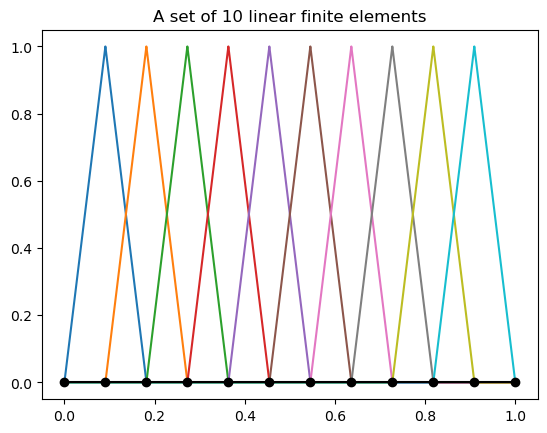

In [3]:
# modify n to change the size of the set of finite linear elements
n = 10

mesh = np.linspace(0,1,n+2)
x = np.linspace(0,1,10000) 

for i in range(n):
    plt.plot(x,lfe_vector(x,i+1,mesh))

plt.plot(mesh,np.zeros(np.size(mesh)),'k-o')
plt.title('A set of '+ str(n) + ' linear finite elements')

**1.2)** Build the Galerkin linear systems in NumPy format for Problem 1 and
Problem 2, and solve them adequately

In [4]:
# funtion to calculate the value at x of the i-th linear finite element for a given mesh
def lfe (x, i, mesh):
    y = 0
    if x > mesh[i-1] and x <= mesh[i]:
        y = (x-mesh[i-1])/(mesh[i]-mesh[i-1])
    elif x > mesh[i] and x < mesh[i+1]:
        y = (mesh[i+1]-x)/(mesh[i+1]-mesh[i])
    return y

# funtion to calculate the value at x of the derivative of the i-th linear finite element for a given mesh
def dlfe (x, i, mesh):
    y = 0
    if x > mesh[i-1] and x <= mesh[i]:
        y = (1)/(mesh[i]-mesh[i-1])
    elif x > mesh[i] and x < mesh[i+1]:
        y = (-1)/(mesh[i+1]-mesh[i])
    return y

def f1(x):
    y = (1 + 5*np.pi**2 - 2 * (1+9*np.pi**2) * (np.cos((np.pi)*x)**2) )*np.sin(np.pi * x) 
    return y

def f2(x):
    y = 2 * ( (1+2*(np.pi**2)*(x**4))*np.sin(np.pi*(x**2)) - 3*np.pi*(x**2)*np.cos(np.pi*(x**2)) ) 
    return y


In [5]:
# This function builds and solves the Galerkin linear system in NumPy format for Problem 1  
def solve_linear1(n):

    mesh = np.linspace(0,1,n+2)
    
    # In order to costruct the symmetric Toeplitz matrix A, I use symmetry to reduce computations
    x,err = integrate.quad(lambda x: dlfe(x,1,mesh)*dlfe(x,1,mesh) + lfe(x,1,mesh)*lfe(x,1,mesh) , 0, mesh[2] )
    y,err = integrate.quad(lambda x: dlfe(x,1,mesh)*dlfe(x,2,mesh) + lfe(x,1,mesh)*lfe(x,2,mesh) , 0,mesh[3] )

    a = np.zeros(n)
    a[0] = x
    a[1] = y
    
    
    F = np.empty(n) 
    for i in range(n):
        result, err = integrate.quad(lambda x: f1(x)*lfe(x,i+1,mesh), mesh[i], mesh[i+2])
        F[i] = result
        
    c = linalg.solve_toeplitz(a,F) 
    return c

In [6]:
# This function builds and solves the Galerkin linear system in NumPy format for Problem 2 
def solve_linear2(n):

    mesh = np.linspace(-1,1,n+2)
    
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            if i-j < 2:
                result, err = integrate.quad(lambda x: (x**2)*dlfe(x,i+1,mesh)*dlfe(x,j+1,mesh) + 2*lfe(x,i+1,mesh)*lfe(x,j+1,mesh) , mesh[j],mesh[i+2] )
                A[i,j] = result
    A = A + np.transpose (np.tril(A,-1))

    F = np.empty(n) 
    for i in range(n):
        result, err =  integrate.quad(lambda x: f2(x)*lfe(x,i+1,mesh), mesh[i], mesh[i+2])
        F[i] = result

    c = linalg.solve(A,F,assume_a='sym') 
    return c

**1.2)** Build the Galerkin linear systems in SymPy format for Problem 1 and
Problem 2, and solve them adequately

In [7]:
x = sym.symbols('x')

#define the i-th linear finite element corresponding to the uniform n+2 knot sequence in the interval [x0,x1]
def lfeS (i, x0, x1, n):
    h = ( x1 - x0 ) / (n+1)
    pl = ( x - x0- (i-1)*h ) / h
    pr = ( x0+(i+1)*h - x ) / h
    expr = sym.Piecewise((0, x < x0+(i-1)*h ), (pl, x < x0 + i*h ) , (pr, x < x0+(i+1)*h ),  (0, True) )
    return expr


In [8]:
#This function builds and solves the Galerkin linear system in SymPy format for Problem 1  
def solve_linear1_sympy(n):
    
    x0 = 0
    x1 = 1
    h = ( x1 - x0 ) / (n+1)
    
    # In order to costruct the symmetric Toeplitz matrix A, I use symmetry to reduce computations
    u = lfeS(1,x0,x1,n)
    v = lfeS(2,x0,x1,n)
    a1 = sym.integrate ( sym.diff(u,x)*sym.diff(u,x) + u*u, (x,0,2*h) )
    a2 = sym.integrate ( sym.diff(u,x)*sym.diff(v,x) + u*v, (x,0,3*h) )

    A = sym.Matrix(n, n, lambda i,j: a1 if i==j else a2 if i-j==1 else a2 if i-j==-1 else 0)

    
    f1 = (1 + 5*sym.pi**2 - 2 * (1+9*sym.pi**2) * (sym.cos((sym.pi)*x)**2) )*sym.sin(sym.pi * x) 
    F = sym.Matrix( n, 1, lambda i, j: sym.integrate( f1*lfeS(i+1,x0,x1,n) , (x,i*h,(i+2)*h) ) )
      
    c = A.cholesky_solve(F) 
    return c

In [9]:
# Bilinear form of problem 2 defined in SymPy format
def a2_sympy(i,j,n):
    x0 = -1
    x1 = 1
    
    if abs(i-j)<2:
        a = sym.integrate ( (x**2)*sym.diff(lfe(i+1,x0,x1,n))*sym.diff(lfe(j+1,x0,x1,n)) + 2*lfe(i+1,x0,x1,n)*lfe(j+1,x0,x1,n), (x,x0,x1) )
    else: 
        a = 0
    return a
    
#This function builds and solves the Galerkin linear system in SymPy format for Problem 1  
def solve_linear2_sympy(n):
    
    x0 = -1
    x1 = 1
    h = ( x1 - x0 ) / (n+1)
    
    A = sym.Matrix(n, n, lambda i,j: a2_sympy(i,j,n) )

    
    f2 = 2 * ( (1+2*(sym.pi**2)*(x**4))*sym.sin(sym.pi*(x**2)) - 3*sym.pi*(x**2)*sym.cos(sym.pi*(x**2)) ) 
    F = sym.Matrix( n, 1, lambda i, j: sym.integrate( f2*lfe(i+1,x0,x1,n) , (x,x0,x1) ) )
      
    c = A.cholesky_solve(F) 
    return c

**1.4)** Visualize the obtained solutions u<sub>h</sub>  approximating the unknown functions u.


(-0.05, 1.05)

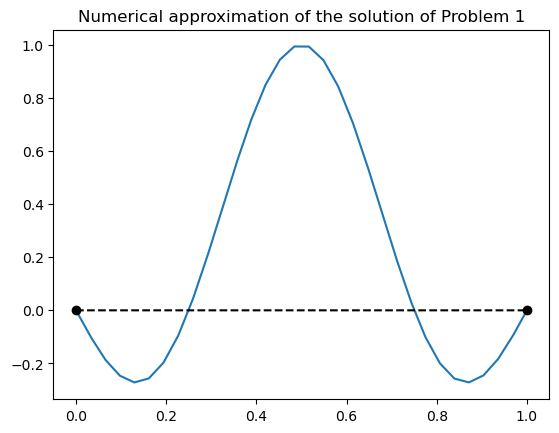

In [10]:
# modify n to change the size of the set of finite linear elements
n = 30

c = solve_linear1(n)
# Uncomment the next line and comment the previous line in order to visualize the solution computed using Sympy 
# c = np.array(solve_linear1_sympy(10).evalf())

x = np.linspace(0,1,10000) 
y = np.zeros(np.size(x))
mesh = np.linspace(0,1,n+2)
for i in range(n):
    y = y + c[i]*lfe_vector(x,i+1,mesh)
    
plt.plot(x,y)
plt.plot(x,np.zeros(np.size(x)),'k--')
plt.plot(0,0,'ko')
plt.plot(1,0,'ko')
plt.title('Numerical approximation of the solution of Problem 1')
plt.xlim(-0.05,1.05)    

(-1.05, 1.05)

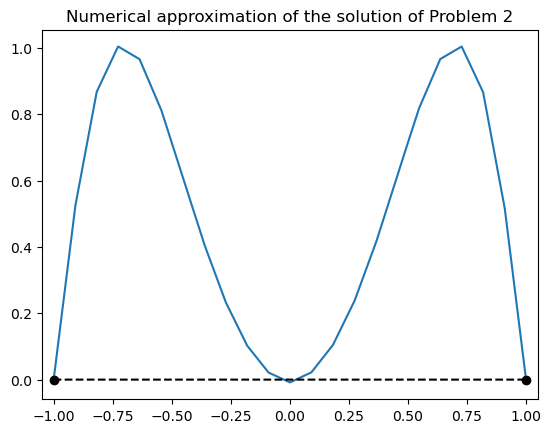

In [11]:
# modify n to change the size of the set of finite linear elements
n = 21

c = solve_linear2(n)
# Uncomment the next line and comment the previous line in order to visualize the solution computed using Sympy 
# c = np.array(solve_linear2_sympy(10).evalf())
# NOTE: solve_linear2_sympy(10) is slow: 3-4 on my computer 

x = np.linspace(-1,1,10000) 
y = np.zeros(np.size(x))
mesh = np.linspace(-1,1,n+2)
for i in range(n):
    y = y + c[i]*lfe_vector(x,i+1,mesh)
    
plt.plot(x,y)
plt.plot(x,np.zeros(np.size(x)),'k--')
plt.plot(-1,0,'ko')
plt.plot(1,0,'ko')
plt.title('Numerical approximation of the solution of Problem 2')
plt.xlim(-1.05,1.05)

**1.5)** Do a numerical convergence study of the error in inf-norm of the linear approximations u<sub>h</sub> in terms of the mesh-size h . Check that the approximation order is O(h<sup>2</sup>).

In [12]:
x = np.linspace(0,1,10000) 

# I appoximate the solution of Problem 1 using a very fine mesh
nH = 5000
cH = solve_linear1(nH)
meshH = np.linspace(0,1,nH+2)
yH = np.zeros(np.size(x))
for i in range(nH):
    yH = yH + cH[i]*lfe_vector(x,i+1,meshH)

Text(0.5, 1.0, 'Visual Check that the approximation order is O(h**2)')

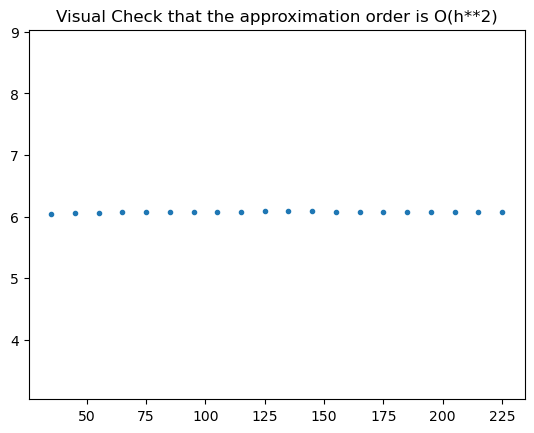

In [13]:
# I find the approximate solution uh relative to some arbitrary mesh-sizes h, 
# and find the error in inf-norm of uh.
error = []
h = []
for j in range(20):
    n = (j+1)*10+25
    c = solve_linear1(n)
    
    mesh = np.linspace(0,1,n+2)
    y = np.zeros(np.size(x))
    for i in range(n):
        y = y + c[i]*lfe_vector(x,i+1,mesh)
        
    error.append( np.linalg.norm(yH-y,np.inf))
    h.append(1/(n+1))
    
temp = np.divide(error,np.power(h,2))
plt.plot(np.divide(1,h)-1, temp, '.')
plt.ylim(temp[0]-3,temp[0]+3)
plt.title("Visual Check that the approximation order is O(h**2)")

In [14]:
x = np.linspace(-1,1,10000) 

# I appoximate the solution of Problem 2 using a very fine mesh
nH = 1000
cH = solve_linear2(nH)
meshH = np.linspace(-1,1,nH+2)
yH = np.zeros(np.size(x))
for i in range(nH):
    yH = yH + cH[i]*lfe_vector(x,i+1,meshH)

Text(0.5, 1.0, 'Visual Check that the approximation order is O(h**2)')

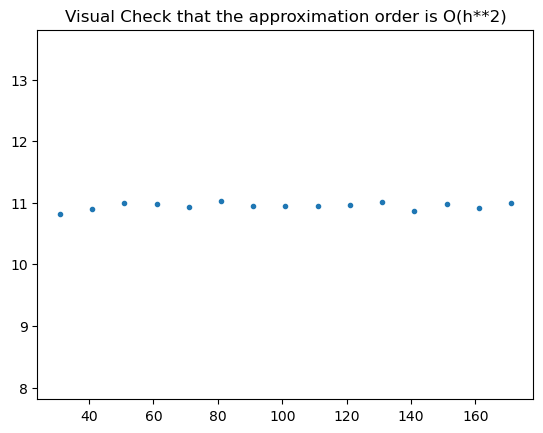

In [15]:
# I find the approximate solution uh relative to some arbitrary mesh-sizes h, 
# and find the error in inf-norm of uh.
error = []
h = []
for j in range(15):
    n = (j+2)*10+10
    c = solve_linear2(n)
    
    mesh = np.linspace(-1,1,n+2)
    y = np.zeros(np.size(x))
    for i in range(n):
        y = y + c[i]*lfe_vector(x,i+1,mesh)
    error.append( np.linalg.norm(yH-y,np.inf))
    h.append(1/(n+1))
    
temp = np.divide(error,np.power(h,2))
plt.plot(np.divide(1,h), temp, '.')
plt.ylim(temp[0]-3,temp[0]+3)
plt.title("Visual Check that the approximation order is O(h**2)")

# Spline approximation

**2.1)** Visualize a set of B-spline finite elements for different degrees p≥1 (say at least p=1,2,3 ) on a given mesh (using a uniform knot sequence in the interval [0,1] ).

In [16]:
def show_spline(n,p):
    # n-2 is the size of the set of finite elements
    # p is the degree
    
    mesh = np.concatenate([np.zeros(p), np.linspace(0,1,n-p+1), np.ones(p)])
    x = np.linspace(0,1,1000) 

    for i in range(n-2):
        B = interpolate.BSpline.basis_element(mesh[i+1:i+1+p+2],extrapolate=False)
        plt.plot(x,B(x))

    plt.plot(mesh,np.zeros(np.size(mesh)),'k-o')
    plt.ylim(-0.05,1.05)
    plt.title('A set of '+ str(n-2) + ' B-spline finite elements of degree '+str(p))

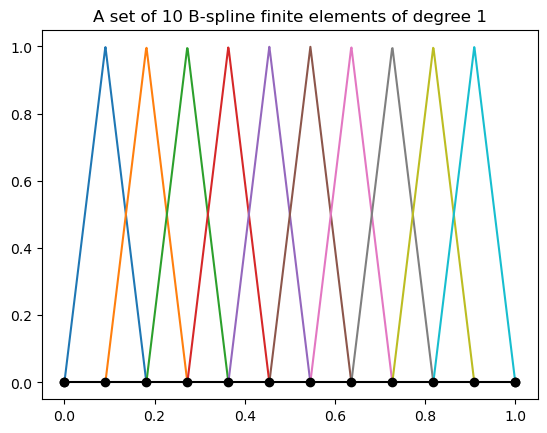

In [17]:
show_spline(12,1)

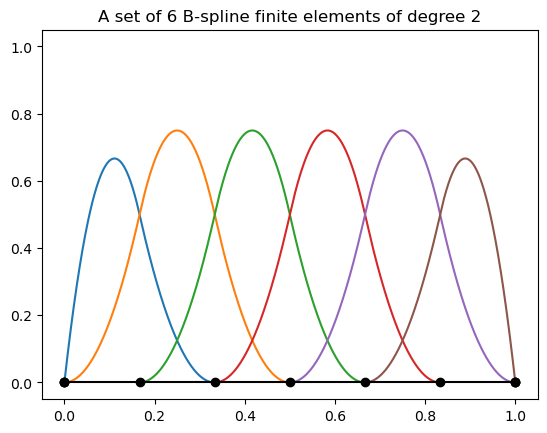

In [18]:
show_spline(8,2)

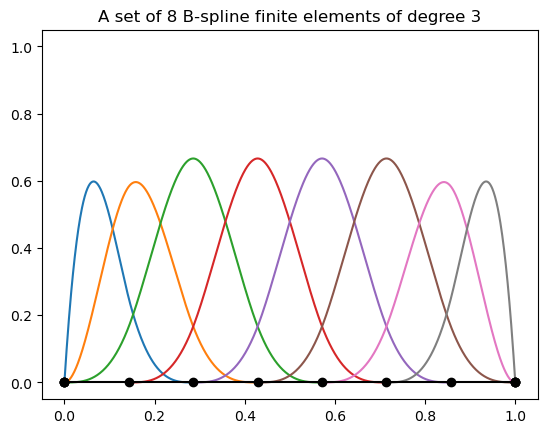

In [19]:
show_spline(10,3)

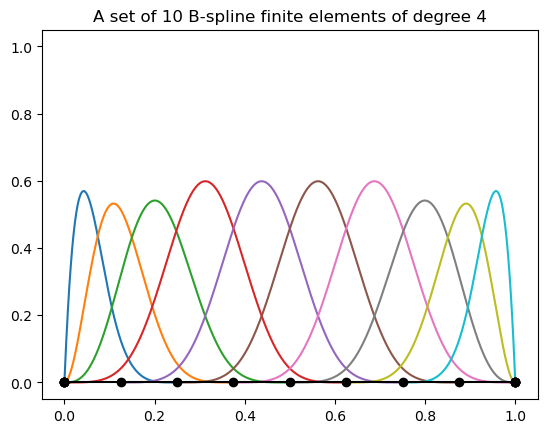

In [20]:
show_spline(12,4)

**2.2)** Build the Galerkin linear systems (see Eq. (4)) in NumPy format for Problem 1 and Problem 2, and solve them adequately.

In [21]:

def a1s(i,j,mesh,p):
    result = [0,0]
    if np.absolute (i-j) < p+1 :
        if i <= j:
            left = mesh[j]
            right = mesh[i+p+1]
        else:
            left = mesh[i]
            right = mesh[j+p+1]  
        spline1 = interpolate.BSpline.basis_element(mesh[i:i+p+2],extrapolate=False)
        spline2 = interpolate.BSpline.basis_element(mesh[j:j+p+2],extrapolate=False)
        Dspline1 = spline1.derivative(nu=1)
        Dspline2 = spline2.derivative(nu=1)
        result = integrate.quad(lambda x: Dspline1(x)*Dspline2(x) + spline1(x)*spline2(x) , left, right )
    return result[0]  
        
def f1(x):
    y = (1 + 5*np.pi**2 - 2 * (1+9*np.pi**2) * (np.cos((np.pi)*x)**2) )*np.sin(np.pi * x) 
    return y

def F1s(i,mesh,p):
    left = mesh[i]
    right = mesh[i+p+1]
    spline = interpolate.BSpline.basis_element(mesh[i:i+p+2],extrapolate=False)
    result =  integrate.quad(lambda x: f1(x)*spline(x), left, right)
    return result[0]



In [22]:
# This function builds and solves the Galerkin linear system in NumPy format for Problem 1  
def solve_spline1(n,p):

    mesh = np.concatenate([np.zeros(p), np.linspace(0,1,n-p+1), np.ones(p)])
    
    a = np.zeros(n-2)
    for i in range(p+1):
        a[i] = a1s(p,p+i,mesh,p)
    A = linalg.toeplitz(a)
    for i in range(p-1):
        for j in range(p+1):
            x = a1s(i+1,j+1,mesh,p)
            A[i,j] = x
            A[j,i] = x
            A[n-3-i,n-3-j] = x
            A[n-3-j,n-3-i] = x
 
    F = np.empty(n-2) 
    for i in range(n-2):
        F[i] = F1s(i+1,mesh,p)
        
    c = linalg.solve(A,F,assume_a='sym') 
    return c

In [23]:
def a2s(i,j,mesh,p):
    result = [0,0]
    if np.absolute (i-j) < p+1 :
        if i <= j:
            left = mesh[j]
            right = mesh[i+p+1]
        else:
            left = mesh[i]
            right = mesh[j+p+1]  
        spline1 = interpolate.BSpline.basis_element(mesh[i:i+p+2],extrapolate=False)
        spline2 = interpolate.BSpline.basis_element(mesh[j:j+p+2],extrapolate=False)
        Dspline1 = spline1.derivative(nu=1)
        Dspline2 = spline2.derivative(nu=1)          
        result, err = integrate.quad(lambda x: (x**2)*Dspline1(x)*Dspline2(x) + 2*spline1(x)*spline2(x) , left,right )
    return result

def f2(x):
    y = 2 * ( (1+2*(np.pi**2)*(x**4))*np.sin(np.pi*(x**2)) - 3*np.pi*(x**2)*np.cos(np.pi*(x**2)) ) 
    return y

def F2s(i,mesh,p):
    left = mesh[i]
    right = mesh[i+p+1]
    spline = interpolate.BSpline.basis_element(mesh[i:i+p+2],extrapolate=False)
    result, err =  integrate.quad(lambda x: f2(x)*spline(x), left, right)
    return result


In [24]:
# This function builds and solves the Galerkin linear system in NumPy format for Problem 2 
def solve_spline2(n,p):

    mesh = np.concatenate([-1*np.ones(p), np.linspace(-1,1,n-p+1), np.ones(p)])
    
    A = np.zeros((n-2,n-2))
    for i in range(n-2):
        for j in range(i+1):
            if i-j < p+1:
                A[i,j] = a2s(i+1,j+1,mesh,p)
    A = A + np.transpose (np.tril(A,-1))

    F = np.empty(n-2) 
    for i in range(n-2):
        F[i] = F2s(i+1,mesh,p)

    c = linalg.solve(A,F,assume_a='sym') 
    return c

**2.3)** Visualize the obtained solutions u<sub>h</sub> approximating the unknown functions u .

(-0.05, 1.05)

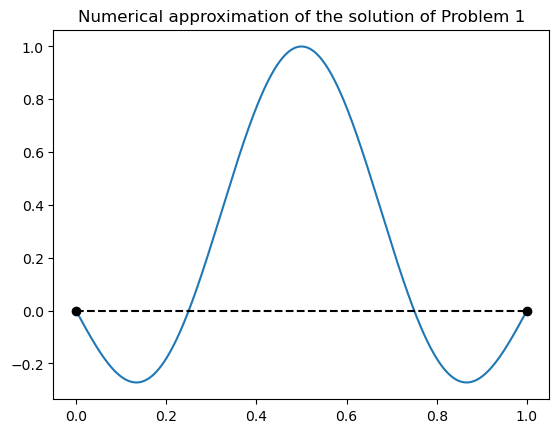

In [25]:
n = 30
p = 4

x = np.linspace(0, 1, 1000)
mesh = np.concatenate([np.zeros(p), np.linspace(0,1,n-p+1), np.ones(p)])

c = solve_spline1(n,p)

zero = np.array([0])
B = interpolate.BSpline(mesh,np.concatenate([zero,c,zero]),p)

plt.plot(x,B(x))
plt.plot(x,np.zeros(np.size(x)),'k--')
plt.plot(0,0,'ko')
plt.plot(1,0,'ko')
plt.title('Numerical approximation of the solution of Problem 1')
plt.xlim(-0.05,1.05)

(-1.05, 1.05)

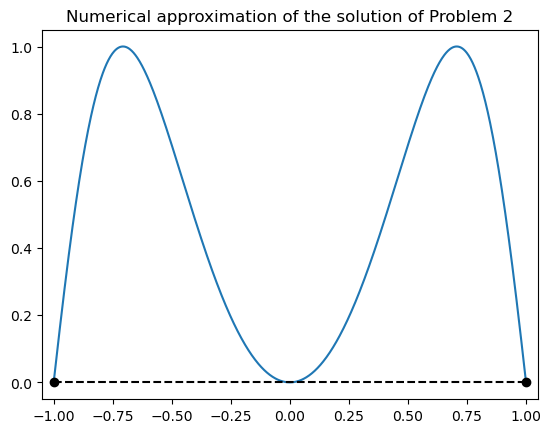

In [26]:
n = 15
p = 4

x = np.linspace(-1, 1, 1000)
mesh = np.concatenate([-1*np.ones(p), np.linspace(-1,1,n-p+1), np.ones(p)])

c = solve_spline2(n,p)

zero = np.array([0])
B = interpolate.BSpline(mesh,np.concatenate([zero,c,zero]),p)

plt.plot(x,B(x))
plt.plot(x,np.zeros(np.size(x)),'k--')
plt.plot(-1,0,'ko')
plt.plot(1,0,'ko')
plt.title('Numerical approximation of the solution of Problem 2')
plt.xlim(-1.05,1.05)

**2.4)** Do a numerical convergence study of the error in inf-norm of the spline approximations u<sub>h</sub> in terms of the mesh-size h for different degrees p≥1 . What is the approximation order? How does it depend on the spline degree p ?


In [27]:
x = np.linspace(0,1,100000) 

# I appoximate the solution of Problem 2 using a very fine mesh and a high degree
nH = 1000
p = 8
cH = solve_spline2(nH,p)
meshH = np.concatenate([-1*np.ones(p), np.linspace(-1,1,nH-p+1), np.ones(p)])

zero = np.array([0])
BH = interpolate.BSpline(meshH,np.concatenate([zero,cH,zero]),p)
yH = BH(x)

Text(0.5, 1.0, 'Visual Check that the approximation order is O(h**3)')

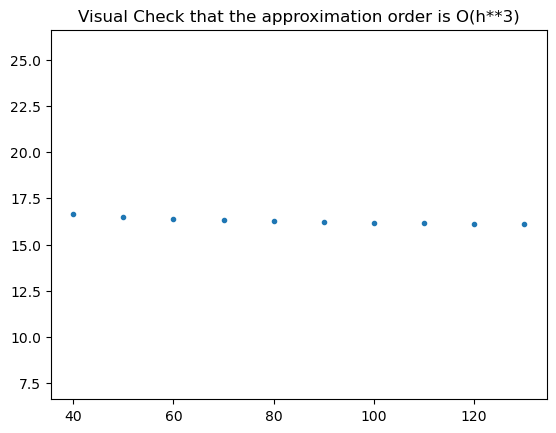

In [28]:
# I find the approximate solution uh relative to some arbitrary mesh-sizes h, 
# and find the error in inf-norm of uh.
# NOTE: the execution of this cell can take some time depending of the degree p
error = []
h = []
p = 2
for j in range(10):
    n = (j*10)+40
    c = solve_spline2(n,p)
    
    mesh = np.concatenate([-1*np.ones(p), np.linspace(-1,1,n-p+1), np.ones(p)])
   
    zero = np.array([0])
    B = interpolate.BSpline(mesh,np.concatenate([zero,c,zero]),p)
    y = B(x)
    error.append( np.linalg.norm(yH-y,np.inf))
    h.append(1/(n-p+1))
    
temp = np.divide(error,np.power(h,p+1))
plt.plot(np.divide(1,h)+p-1, temp, '.')
plt.ylim(temp[0]-10,temp[0]+10)
plt.title("Visual Check that the approximation order is O(h**"+str(p+1)+")")

As shown by the graph above the approximation order is p+1 for the spline approximation with degree p.